<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
<center>Автор материала: Ефремова Дина (@ldinka).

# <center>Исследование возможностей BigARTM</center>

## <center>Тематическое моделирование с помощью BigARTM</center>

#### Интро

BigARTM — библиотека, предназначенная для тематической категоризации текстов; делает разбиение на темы без «учителя».

Я собираюсь использовать эту библиотеку для собственных нужд в будущем, но так как она не предназначена для обучения с учителем, решила, что для начала ее стоит протестировать на какой-нибудь уже размеченной выборке. Для этих целей был использован датасет "20 news groups".

Идея экперимента такова:
- делим выборку на обучающую и тестовую;
- обучаем модель на обучающей выборке;
- «подгоняем» выделенные темы под действительные;
- смотрим, насколько хорошо прошло разбиение;
- тестируем модель на тестовой выборке.

#### Поехали!

**Внимание!** Данный проект был реализован с помощью Python 3.6 и BigARTM 0.9.0. Методы, рассмотренные здесь, могут отличаться от методов в других версиях библиотеки.

<img src="../../img/bigartm_logo.png"/>

### <font color="lightgrey">Не</font>множко теории

У нас есть словарь терминов $W = \{w \in W\}$, который представляет из себя мешок слов, биграмм или n-грамм;

Есть коллекция документов $D = \{d \in D\}$, где $d \subset W$;

Есть известное множество тем $T = \{t \in T\}$;

$n_{dw}$ — сколько раз термин $w$ встретился в документе $d$;

$n_{d}$ — длина документа $d$.

Мы считаем, что существует матрица $\Phi$ распределения терминов $w$ в темах $t$: (фи) $\Phi = (\phi_{wt})$

и матрица распределения тем $t$ в документах $d$: (тета) $\Theta = (\theta_{td})$,

переумножение которых дает нам тематическую модель, или, другими словами, представление наблюдаемого условного распределения $p(w|d)$ терминов $w$ в документах $d$ коллекции $D$:

<center>$\large p(w|d) = \Phi \Theta$</center>

<center>$$\large p(w|d) = \sum_{t \in T} \phi_{wt} \theta_{td}$$</center>

где $\phi_{wt} = p(w|t)$ — вероятности терминов $w$ в каждой теме $t$

и $\theta_{td} = p(t|d)$ — вероятности тем $t$ в каждом документе $d$.

<img src="../../img/phi_theta.png"/>

Нам известны наблюдаемые частоты терминов в документах, это:

<center>$ \large \hat{p}(w|d) = \frac {n_{dw}} {n_{d}} $</center>

Таким образом, наша задача тематического моделирования становится задачей стохастического матричного разложения матрицы $\hat{p}(w|d)$ на стохастические матрицы $\Phi$ и $\Theta$.

Напомню, что матрица является стохастической, если каждый ее столбец представляет дискретное распределение вероятностей, сумма значений каждого столбца равна 1.

Воспользовавшись принципом максимального правдоподобия, т. е. максимизируя логарифм правдоподобия, мы получим:

<center>$
\begin{cases}
\sum_{d \in D} \sum_{w \in d} n_{dw} \ln \sum_{t \in T} \phi_{wt} \theta_{td} \rightarrow \max\limits_{\Phi,\Theta};\\
\sum_{w \in W} \phi_{wt} = 1, \qquad \phi_{wt}\geq0;\\
\sum_{t \in T} \theta_{td} = 1, \quad\quad\;\; \theta_{td}\geq0.
\end{cases}
$</center>

Чтобы из множества решений выбрать наиболее подходящее, введем критерий регуляризации $R(\Phi, \Theta)$:

<center>$
\begin{cases}
\sum_{d \in D} \sum_{w \in d} n_{dw} \ln \sum_{t \in T} \phi_{wt} \theta_{td} + R(\Phi, \Theta) \rightarrow \max\limits_{\Phi,\Theta};\\
\sum_{w \in W} \phi_{wt} = 1, \qquad \phi_{wt}\geq0;\\
\sum_{t \in T} \theta_{td} = 1, \quad\quad\;\; \theta_{td}\geq0.
\end{cases}
$</center>

Два наиболее известных частных случая этой системы уравнений:
- **PLSA**, вероятностный латентный семантический анализ, когда $R(\Phi, \Theta) = 0$
- **LDA**, латентное размещение Дирихле:
$$R(\Phi, \Theta) = \sum_{t,w} (\beta_{w} - 1) \ln \phi_{wt} + \sum_{d,t} (\alpha_{t} - 1) \ln \theta_{td} $$
где $\beta_{w} > 0$, $\alpha_{t} > 0$ — параметры регуляризатора.

Однако оказывается запас неединственности решения настолько большой, что на модель можно накладывать сразу несколько ограничений, такой подход называется **ARTM**, или аддитивной регуляризацией тематических моделей:

<center>$
\begin{cases}
\sum_{d,w} n_{dw} \ln \sum_{t} \phi_{wt} \theta_{td} + \sum_{i=1}^k \tau_{i} R_{i}(\Phi, \Theta) \rightarrow \max\limits_{\Phi,\Theta};\\
\sum_{w \in W} \phi_{wt} = 1, \qquad \phi_{wt}\geq0;\\
\sum_{t \in T} \theta_{td} = 1, \quad\quad\;\; \theta_{td}\geq0.
\end{cases}
$</center>

где $\tau_{i}$ — коэффициенты регуляризации.

Теперь давайте познакомимся с библиотекой BigARTM и разберем еще некоторые аспекты тематического моделирования на ходу.

Если Вас очень сильно заинтересовала теоретическая часть категоризации текстов и тематического моделирования, рекомендую посмотреть видеолекции из курса Яндекса на Coursera «Поиск структуры в данных» четвертой недели: <a href="https://www.coursera.org/learn/unsupervised-learning/home/week/4">Тематическое моделирование</a>.

### BigARTM

#### Установка

Естественно, для начала работы с библиотекой ее надо установить. Вот несколько видео, которые рассказывают, как это сделать в зависимости от вашей операционной системы:
- <a href="https://www.coursera.org/learn/unsupervised-learning/lecture/qmsFm/ustanovka-bigartm-v-windows">Установка BigARTM в Windows</a>
- <a href="https://www.coursera.org/learn/unsupervised-learning/lecture/zPyO0/ustanovka-bigartm-v-linux-mint">Установка BigARTM в Linux</a>
- <a href="https://www.coursera.org/learn/unsupervised-learning/lecture/nuIhL/ustanovka-bigartm-v-mac-os-x">Установка BigARTM в Mac OS X</a>

Либо можно воспользоваться инструкцией с официального сайта, которая, скорее всего, будет гораздо актуальнее: <a href="https://bigartm.readthedocs.io/en/stable/installation/index.html">здесь</a>. Там же указано, как можно установить BigARTM в качестве <a href="https://bigartm.readthedocs.io/en/stable/installation/docker.html">Docker-контейнера</a>.

#### Использование BigARTM

In [926]:
import artm
import re
import numpy as np
import seaborn as sns; sns.set()

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
artm.version()

'0.9.0'

Скачаем датасет ***the 20 news groups*** с заранее известным количеством категорий новостей:

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
newsgroups = fetch_20newsgroups('../../data/news_data')

In [5]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Приведем данные к формату *Vowpal Wabbit*. Так как BigARTM не рассчитан на обучение с учителем, то мы поступим следующим образом:
- обучим модель на всем корпусе текстов;
- выделим ключевые слова тем и по ним определим, к какой теме они скорее всего относятся;
- сравним наши полученные результаты разбиения с истинными значенями.

In [6]:
TEXT_FIELD = "text"

In [643]:
def to_vw_format(document, label=None):
    return str(label or '0') + ' |' + TEXT_FIELD + ' ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

<input>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-643-9a4f2d073677>:2: DeprecationWarning: invalid escape sequence \w
  return str(label or '0') + ' |' + TEXT_FIELD + ' ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'


In [644]:
all_documents = newsgroups['data']
all_targets = newsgroups['target']
len(newsgroups['target'])

11314

In [851]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)

with open('../../data/news_data/20news_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open('../../data/news_data/20news_test_mult.vw', 'w') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Загрузим данные в необходимый для BigARTM формат:

In [894]:
batch_vectorizer = artm.BatchVectorizer(data_path="../../data/news_data/20news_train_mult.vw",
                                        data_format="vowpal_wabbit",
                                        target_folder="news_batches")

Данные в BigARTM загружаются порционно, укажем в 
- *data_path* путь к обучающей выборке,
- *data_format* — формат наших данных, может быть:
    * *bow_n_wd* — это вектор $n_{wd}$ в виду массива *numpy.ndarray*, также необходимо передать соответствующий словарь терминов, где ключ — это индекс вектора *numpy.ndarray* $n_{wd}$, а значение — соответствующий токен.
    ```python
    batch_vectorizer = artm.BatchVectorizer(data_format='bow_n_wd',
                                              n_wd=n_wd,
                                              vocabulary=vocabulary)
    ```
    * *vowpal_wabbit* — формат Vowpal Wabbit;
    * *bow_uci* — UCI формат (например, с *vocab.my_collection.txt* и *docword.my_collection.txt* файлами):
    ```python
    batch_vectorizer = artm.BatchVectorizer(data_path='',
                                              data_format='bow_uci',
                                              collection_name='my_collection',
                                              target_folder='my_collection_batches')
    ```
    * *batches* — данные, уже сконверченные в батчи с помощью BigARTM;
- *target_folder* — путь для сохранения батчей.

Пока это все параметры, что нам нужны для загрузки наших данных.

После того, как BigARTM создал батчи из данных, можно использовать их для загрузки:

In [895]:
batch_vectorizer = artm.BatchVectorizer(data_path="news_batches", data_format='batches')

Инициируем модель с известным нам количеством тем. Количество тем — это гиперпараметр, поэтому если он заранее нам неизвестен, то его необходимо настраивать, т. е. брать такое количество тем, при котором разбиение кажется наиболее удачным.

**Важно!** У нас 20 предметных тем, однако некоторые из них довольно узкоспециализированны и смежны, как например 'comp.os.ms-windows.misc' и 'comp.windows.x', или 'comp.sys.ibm.pc.hardware' и 'comp.sys.mac.hardware', тогда как другие размыты и всеобъемлющи: talk.politics.misc' и 'talk.religion.misc'.

Скорее всего, нам не удастся в чистом виде выделить все 20 тем — некоторые из них окажутся слитными, а другие наоборот раздробятся на более мелкие. Поэтому мы попробуем построить 40 «предметных» тем и одну фоновую. Чем больше вы будем строить категорий, тем лучше мы сможем подстроиться под данные, однако это довольно трудоемкое занятие сидеть потом и распределять в получившиеся темы по реальным категориям (<strike>я правда очень-очень задолбалась!</strike>).

Зачем нужны фоновые темы? Дело в том, что наличие общей лексики в темах приводит к плохой ее интерпретируемости. Выделив общую лексику в отдельную тему, мы сильно снизим ее количество в предметных темах, таким образом оставив там лексическое ядро, т. е. ключевые слова, которые данную тему характеризуют. Также этим преобразованием мы снизим коррелированность тем, они станут более независимыми и различимыми.

In [2094]:
T = 41
model_artm = artm.ARTM(num_topics=T,
                       topic_names=[str(i) for i in range(T)],
                       class_ids={TEXT_FIELD:1}, 
                       num_document_passes=1,
                       reuse_theta=True,
                       cache_theta=True,
                       seed=4)

Передаем в модель следующие параметры:
- *num_topics* — количество тем;
- *topic_names* — названия тем;
- *class_ids* — название модальности и ее вес. Дело в том, что кроме самих текстов, в данных может содержаться такая информация, как автор, изображения, ссылки на другие документы и т. д., по которым также можно обучать модель;
- *num_document_passes* — количество проходов при обучении модели;
- *reuse_theta* — переиспользовать ли матрицу $\Theta$ с предыдущей итерации;
- *cache_theta* — сохранить ли матрицу $\Theta$ в модели, чтобы в дальнейшем ее использовать.

Далее необходимо создать словарь; передадим ему какое-нибудь название, которое будем использовать в будущем для работы с этим словарем.

In [2095]:
DICTIONARY_NAME = 'dictionary'

dictionary = artm.Dictionary(DICTIONARY_NAME)
dictionary.gather(batch_vectorizer.data_path)

Инициализируем модель с тем именем словаря, что мы передали выше, можно зафиксировать *random seed* для вопроизводимости результатов:

In [2096]:
np.random.seed(1)
model_artm.initialize(DICTIONARY_NAME)

Добавим к модели несколько метрик:
- перплексию (*PerplexityScore*), чтобы индентифицировать сходимость модели
    * Перплексия — это известная в вычислительной лингвистике мера качества модели языка. Можно сказать, что это мера неопределенности или различности слов в тексте.
- специальный *score* ключевых слов (*TopTokensScore*), чтобы в дальнейшем мы могли идентифицировать по ним наши тематики;
- разреженность матрицы $\Phi$ (*SparsityPhiScore*);
- разреженность матрицы $\Theta$ (*SparsityThetaScore*).

In [2097]:
model_artm.scores.add(artm.PerplexityScore(name='perplexity_score',
                                           dictionary=DICTIONARY_NAME))
model_artm.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id=TEXT_FIELD))

Следующая операция *fit_offline* займет некоторое время, мы будем обучать модель в режиме *offline* в 40 проходов. Количество проходов влияет на сходимость модели: чем их больше, тем лучше сходится модель.

In [2098]:
%%time

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

CPU times: user 3min 47s, sys: 14.9 s, total: 4min 2s
Wall time: 1min 49s


Построим график сходимости модели и увидим, что модель сходится довольно быстро:

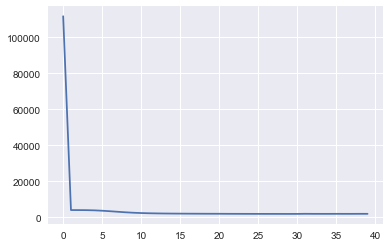

In [2099]:
plt.plot(model_artm.score_tracker["perplexity_score"].value);

Выведем значения разреженности матриц:

In [2100]:
print('Phi', model_artm.score_tracker["sparsity_phi_score"].last_value)
print('Theta', model_artm.score_tracker["sparsity_theta_score"].last_value)

Phi 0.9166713356971741
Theta 0.14179398119449615


После того, как модель сошлась, добавим к ней регуляризаторы. Для начала сглаживающий регуляризатор — это *SmoothSparsePhiRegularizer* с большим положительным коэффициентом $\tau$, который нужно применить только к фоновой теме, чтобы выделить в нее как можно больше общей лексики. Пусть тема с последним индексом будет фоновой, передадим в *topic_names* этот индекс:

In [2102]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', 
                                                            tau=1e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=TEXT_FIELD,
                                                            topic_names=str(T-1)))

Дообучим модель, сделав 20 проходов по ней с новым регуляризатором:

In [2103]:
%%time

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

CPU times: user 2min 2s, sys: 8.44 s, total: 2min 11s
Wall time: 1min 3s


Выведем значения разреженности матриц, заметим, что значение для $\Theta$ немного увеличилось:

In [2104]:
print('Phi', model_artm.score_tracker["sparsity_phi_score"].last_value)
print('Theta', model_artm.score_tracker["sparsity_theta_score"].last_value)

Phi 0.9079725742340088
Theta 0.25141066312789917


Теперь добавим к модели разреживающий регуляризатор, это тот же *SmoothSparsePhiRegularizer* резуляризатор, только с отрицательным значением $\tau$ и примененный ко всем предметным темам:

In [2106]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2', 
                                                            tau=-5e5, 
                                                            dictionary=dictionary, 
                                                            class_ids=TEXT_FIELD,
                                                            topic_names=[str(i) for i in range(T-1)]),
                                                            overwrite=True)

In [2107]:
%%time

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

CPU times: user 2min 2s, sys: 8.46 s, total: 2min 10s
Wall time: 1min 2s


Видим, что значения разреженности увеличились еще больше:

In [1699]:
print(model_artm.score_tracker["sparsity_phi_score"].last_value)
print(model_artm.score_tracker["sparsity_theta_score"].last_value)

0.9571115374565125
0.900256335735321


Посмотрим, сколько категорий-строк матрицы $\Theta$ после регуляризации осталось, т. е. не занулилось/выродилось. И это одна категория:

In [1700]:
len(model_artm.score_tracker["top_words"].last_tokens.keys())

40

Теперь выведем ключевые слова тем, чтобы определить, каким образом прошло разбиение, и сделать соответствие с нашим начальным списком тем:

In [2111]:
for topic_name in model_artm.score_tracker["top_words"].last_tokens.keys():
    tokens = model_artm.score_tracker["top_words"].last_tokens
    res_str = topic_name + ': ' + ', '.join(tokens[topic_name])
    print(res_str)

0: adaptec, aspi4dos, 1542, dma, scsiha, cdrom, fielder, fulk, acne, buffering, qemm, gaetti, inode, zeos, 1542a
1: shagen, istanbul, igor, emma, salonica, aiu, osmanli, ankara, ermeni, donot, nun, flax, umumiye, nezareti, mecmuasi
2: ground, wire, circuit, wiring, radar, audio, voltage, neutral, electronics, amp, detector, outlets, outlet, circuits, electrical
3: team, hockey, play, leafs, flyers, period, detroit, fans, cup, montreal, wings, rangers, goal, playoffs, played
4: vitamin, infected, carcinogenic, candida, kidney, oxalic, clubbing, theseus, sasghm, oxalate, unx, tray, transgenic, nutrition, magnesium
5: bike, dod, ride, motorcycle, bikes, bmw, riding, rider, helmet, dog, motorcycles, bnr, behanna, harley, ama
6: tiff, den, tobacco, os2, smokeless, sphere, 3do, coli, lyme, o157, quicktime, photography, radius, jpeg, thrush
7: pts, bos, tor, det, nyr, chi, nyi, pit, jets, que, phi, ott, edm, har, cal
8: israel, jews, turkish, armenian, israeli, armenians, turks, armenia, turk

Далее мы будем подгонять разбиение под действительные темы с помощью *confusion matrix*.

In [2108]:
target_dict = {
    'alt.atheism': 0,
    'comp.graphics': 1,
    'comp.os.ms-windows.misc': 2,
    'comp.sys.ibm.pc.hardware': 3,
    'comp.sys.mac.hardware': 4,
    'comp.windows.x': 5,
    'misc.forsale': 6,
    'rec.autos': 7,
    'rec.motorcycles': 8,
    'rec.sport.baseball': 9,
    'rec.sport.hockey': 10,
    'sci.crypt': 11,
    'sci.electronics': 12,
    'sci.med': 13,
    'sci.space': 14,
    'soc.religion.christian': 15,
    'talk.politics.guns': 16,
    'talk.politics.mideast': 17,
    'talk.politics.misc': 18,
    'talk.religion.misc': 19
}

In [2443]:
mixed = [
    'comp.sys.ibm.pc.hardware',
    'talk.politics.mideast',
    'sci.electronics',
    'rec.sport.hockey',

    'sci.med',
    'rec.motorcycles',
    'comp.graphics',
    'rec.sport.hockey',

    'talk.politics.mideast',
    'talk.religion.misc',
    'rec.autos',
    'comp.graphics',

    'sci.space',
    'soc.religion.christian',
    'comp.os.ms-windows.misc',
    'sci.crypt',

    'comp.windows.x',
    'misc.forsale',
    'sci.space',
    'sci.crypt',

    'talk.religion.misc',
    'alt.atheism',
    'comp.os.ms-windows.misc',
    'alt.atheism',
    
    'sci.med',
    'comp.os.ms-windows.misc',
    'soc.religion.christian',
    'talk.politics.guns',

    'rec.autos',
    'rec.autos',
    'talk.politics.mideast',
    'rec.sport.baseball',

    'talk.religion.misc',
    'talk.politics.misc',
    'rec.sport.hockey',
    'comp.sys.mac.hardware',

    'misc.forsale',
    'sci.space',
    'talk.politics.guns',
    'rec.autos',
    
    '-'
]

Построим небольшой отчет о правильности нашего разбиения:

In [2444]:
theta_train = model_artm.get_theta()
model_labels = []
keys = np.sort([int(i) for i in theta_train.keys()])
for i in keys:
    max_val = 0
    max_idx = 0
    for j in theta_train[i].keys():
        if j == str(T-1):
            continue
        if theta_train[i][j] > max_val:
            max_val = theta_train[i][j]
            max_idx = j
    topic = mixed[int(max_idx)]
    if topic == '-':
        print(i, '-')
    label = target_dict[topic]
    model_labels.append(label)

In [2445]:
print(classification_report(train_labels, model_labels))

             precision    recall  f1-score   support

          0       0.92      0.93      0.92       360
          1       0.56      0.99      0.71       436
          2       0.64      0.53      0.58       439
          3       0.44      0.14      0.22       458
          4       0.40      0.66      0.50       430
          5       0.82      0.44      0.57       450
          6       0.86      0.71      0.78       449
          7       0.77      0.92      0.84       465
          8       0.95      0.91      0.93       440
          9       0.99      0.89      0.94       452
         10       0.95      0.99      0.97       446
         11       0.88      1.00      0.93       437
         12       0.81      0.90      0.85       439
         13       0.95      0.65      0.77       427
         14       0.85      0.93      0.89       446
         15       0.86      0.98      0.92       440
         16       0.92      1.00      0.96       420
         17       0.98      0.99      0.98   

In [2446]:
print(classification_report(train_labels, model_labels))

             precision    recall  f1-score   support

          0       0.92      0.93      0.92       360
          1       0.56      0.99      0.71       436
          2       0.64      0.53      0.58       439
          3       0.44      0.14      0.22       458
          4       0.40      0.66      0.50       430
          5       0.82      0.44      0.57       450
          6       0.86      0.71      0.78       449
          7       0.77      0.92      0.84       465
          8       0.95      0.91      0.93       440
          9       0.99      0.89      0.94       452
         10       0.95      0.99      0.97       446
         11       0.88      1.00      0.93       437
         12       0.81      0.90      0.85       439
         13       0.95      0.65      0.77       427
         14       0.85      0.93      0.89       446
         15       0.86      0.98      0.92       440
         16       0.92      1.00      0.96       420
         17       0.98      0.99      0.98   

/Users/ldinka/miniconda2/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


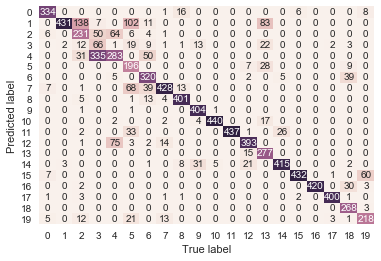

In [2447]:
mat = confusion_matrix(train_labels, model_labels)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [2434]:
accuracy_score(train_labels, model_labels)

0.80070713022981732

Нам удалось добиться 80% *accuracy*. По матрице ответов мы видим, что для модели темы *comp.sys.ibm.pc.hardware* и *comp.sys.mac.hardware* практически не различимы (<strike>честно говоря, для меня тоже</strike>), в остальном все более или менее прилично.

Проверим модель на тестовой выборке:

In [1657]:
batch_vectorizer_test = artm.BatchVectorizer(data_path="../../data/news_data/20news_test_mult.vw",
                                             data_format="vowpal_wabbit",
                                             target_folder="news_batches_test")

In [2435]:
theta_test = model_artm.transform(batch_vectorizer_test)

In [2436]:
test_score = []
for i in range(len(theta_test.keys())):
    max_val = 0
    max_idx = 0
    for j in theta_test[i].keys():
        if j == str(T-1):
            continue
        if theta_test[i][j] > max_val:
            max_val = theta_test[i][j]
            max_idx = j
    topic = mixed[int(max_idx)]
    label = target_dict[topic]
    test_score.append(label)

In [2438]:
print(classification_report(test_labels, test_score))

             precision    recall  f1-score   support

          0       0.87      0.88      0.88       120
          1       0.51      0.86      0.64       148
          2       0.63      0.43      0.52       152
          3       0.20      0.02      0.03       132
          4       0.36      0.68      0.47       148
          5       0.87      0.51      0.64       143
          6       0.88      0.52      0.65       136
          7       0.84      0.83      0.84       129
          8       0.91      0.95      0.93       158
          9       0.87      0.94      0.91       145
         10       0.91      0.97      0.94       154
         11       0.85      0.97      0.91       158
         12       0.74      0.82      0.78       152
         13       0.97      0.74      0.84       167
         14       0.89      0.91      0.90       147
         15       0.77      0.93      0.84       159
         16       0.87      0.94      0.90       126
         17       0.85      0.98      0.91   

/Users/ldinka/miniconda2/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:


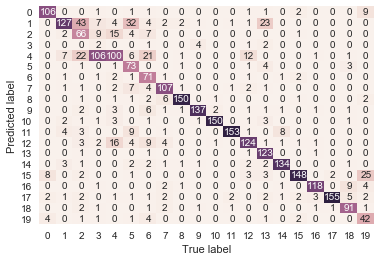

In [2439]:
mat = confusion_matrix(test_labels, test_score)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [2448]:
accuracy_score(test_labels, test_score)

0.76952986921173561

Итого почти 77%, незначительно хуже, чем на обучающей.

**Вывод:** безумно много времени пришлось потратить на подгонку категорий к реальным темам, но в итоге я осталась довольна результатом. Такие смежные темы, как *alt.atheism*/*soc.religion.christian*/*talk.religion.misc* или *talk.politics.guns*/*talk.politics.mideast*/*talk.politics.misc* разделились вполне неплохо. Думаю, что я все-таки попробую использовать BigARTM в будущем для своих <strike>корыстных</strike> целей.